In [1]:

import os
import numpy as np
import zipfile
import pandas as pd
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import csv
import cv2

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="1Ew0Rg3kbVvfDLHUTBGf")
project = rf.workspace("yzu").project("good-bad-bean")
dataset = project.version(1).download("tensorflow")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=f195f48ae11ef2219f5ad4e631cfa264d63d946916e7273cf333e3c6fd61a4cf
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to Good-Bad-Bean-1 in tensorflow:: 100%|██████████| 4359/4359 [00:01<00:00, 2808.88it/s]


In [14]:
TRAINING_FILE = '/content/Good-Bad-Bean-1/train/_annotations.csv'

VALIDATION_FILE = '/content/Good-Bad-Bean-1/valid/_annotations.csv'

In [15]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
filename,width,height,class,xmin,ymin,xmax,ymax

Each subsequent line (data points) look like this:
72a2b8f8-c7ca-4222-b2a1-9b82ac7990f4_45_jpg.rf.d17ad7cb4225bfc8720a0543682e6c22.jpg,416,416,good bean,56,1,341,397



In [16]:
def parse_data_from_input(filename):
    dataframe = pd.read_csv(filename)
    label_mapping = {'good bean': 0, 'bad bean': 1}
    dataframe['class'] = dataframe['class'].map(label_mapping)

    images = []
    labels = []

    for _, row in dataframe.iterrows():
        image_filename = row['filename']
        image_path = os.path.join(os.path.dirname(filename), image_filename)
        image = cv2.imread(image_path)
        image = cv2.blur(image, (5, 5), 0)

        x_min = row['xmin']
        y_min = row['ymin']
        x_max = row['xmax']
        y_max = row['ymax']

        cropped_image = image[y_min:y_max, x_min:x_max]
        resized_image = cv2.resize(cropped_image, (64, 64))
        reshaped_image = np.expand_dims(resized_image, axis=0)
        images.append(reshaped_image)
        labels.append(row['class'])

    images = np.concatenate(images, axis=0)
    labels = np.array(labels)

    return images, labels

In [17]:

# Test your function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (3807, 64, 64, 3) and dtype: uint8
Training labels has shape: (3807,) and dtype: int64
Validation images has shape: (363, 64, 64, 3) and dtype: uint8
Validation labels has shape: (363,) and dtype: int64


In [18]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
    """
    Creates the training and validation data generators

    Args:
        training_images (array): parsed images from the train CSV file
        training_labels (array): parsed labels from the train CSV file
        validation_images (array): parsed images from the test CSV file
        validation_labels (array): parsed labels from the test CSV file

    Returns:
        train_generator, validation_generator - tuple containing the generators
    """


    # Instantiate the ImageDataGenerator class
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Pass in the appropriate arguments to the flow method
    train_generator = train_datagen.flow(
        x=training_images,
        y=training_labels,
        batch_size=32
    )

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    # Remember that validation data should not be augmented
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Pass in the appropriate arguments to the flow method
    validation_generator = validation_datagen.flow(
        x=validation_images,
        y=validation_labels,
        batch_size=32
    )

    return train_generator, validation_generator

train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator[0][0].shape}")
print(f"Labels of training generator have shape: {train_generator[0][1].shape}")
print(f"Images of validation generator have shape: {validation_generator[0][0].shape}")
print(f"Labels of validation generator have shape: {validation_generator[0][1].shape}")

Images of training generator have shape: (32, 64, 64, 3)
Labels of training generator have shape: (32,)
Images of validation generator have shape: (32, 64, 64, 3)
Labels of validation generator have shape: (32,)


In [19]:
def create_model():

  ### START CODE HERE       

  # Define the model
  # Use no more than 2 Conv2D and 2 MaxPooling2D
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(64,64,3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(256,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(),
      # 512 neuron hidden layer
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(2, activation='softmax'),
  ])
  

  model.compile(optimizer ='adam',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  ### END CODE HERE       
  
  return model

In [21]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') is not None and logs.get('accuracy') > 0.93):
            print("\nReached target accuracy so cancelling training!")
            self.model.stop_training = True
        

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
model = create_model()
#Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Model checkpoint callback
checkpoint = ModelCheckpoint('best_model_coba2.h5', monitor='val_loss', save_best_only=True)

# Learning rate scheduling callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

#accuracy threshold callback
callbacks = myCallback()

#train the model
model.fit(train_generator,
          epochs=100,
          validation_data=validation_generator,
          callbacks=[callbacks,early_stopping, checkpoint, reduce_lr])

Epoch 1/100
119/119 [==============================] - 10s 60ms/step - loss: 0.5280 - accuracy: 0.7568 - val_loss: 0.4686 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - 9s 73ms/step - loss: 0.4869 - accuracy: 0.7896 - val_loss: 0.4292 - val_accuracy: 0.8430 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - 6s 54ms/step - loss: 0.4797 - accuracy: 0.7838 - val_loss: 0.4421 - val_accuracy: 0.8402 - lr: 0.0010
Epoch 4/100
119/119 [==============================] - 7s 59ms/step - loss: 0.4690 - accuracy: 0.7983 - val_loss: 0.4006 - val_accuracy: 0.8512 - lr: 0.0010
Epoch 5/100
119/119 [==============================] - 8s 66ms/step - loss: 0.4529 - accuracy: 0.8027 - val_loss: 0.3948 - val_accuracy: 0.8457 - lr: 0.0010
Epoch 6/100
119/119 [==============================] - 6s 49ms/step - loss: 0.4352 - accuracy: 0.8106 - val_loss: 0.3981 - val_accuracy: 0.8430 - lr: 0.0010
Epoch 7/100
119/119 [==============================] - 8s

In [ ]:
# Save the entire model as a SavedModel.
model.save('crop_classification_model2')


INFO:tensorflow:Assets written to: crop_classification_model2\assets


INFO:tensorflow:Assets written to: crop_classification_model2\assets


In [24]:
#save the model as hdf5 file
model.save('crop_classification_model4.h5')

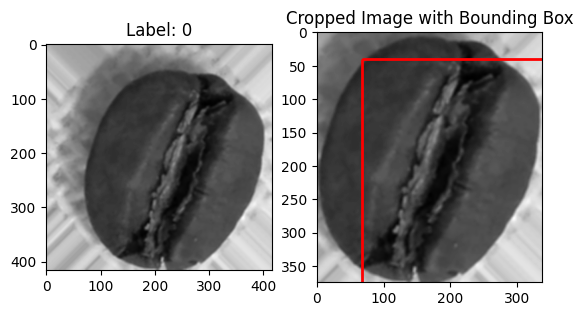

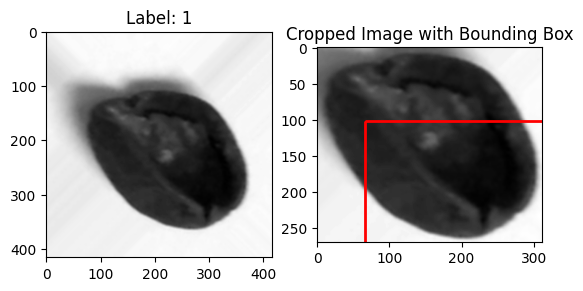

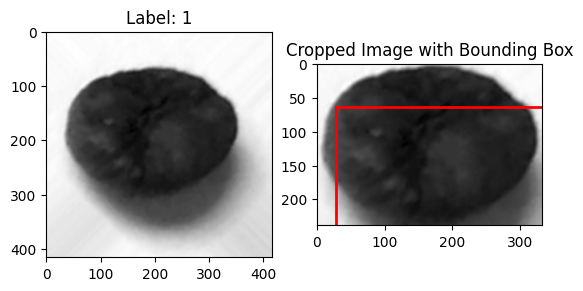

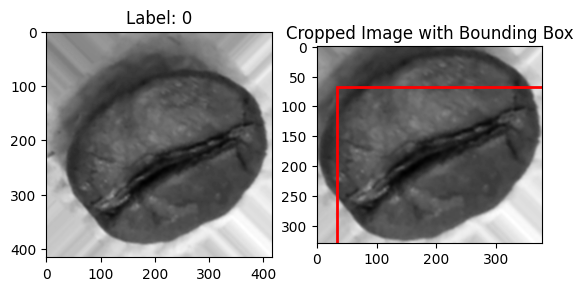

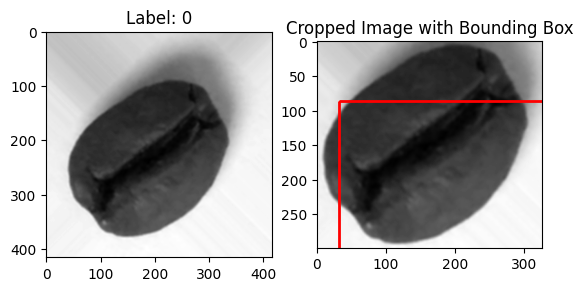

Unique labels: [0 1]
Sample images: [[[[148]
   [139]
   [105]
   ...
   [175]
   [165]
   [186]]

  [[144]
   [108]
   [ 97]
   ...
   [167]
   [188]
   [192]]

  [[127]
   [106]
   [ 97]
   ...
   [189]
   [193]
   [195]]

  ...

  [[164]
   [189]
   [185]
   ...
   [200]
   [189]
   [186]]

  [[191]
   [182]
   [156]
   ...
   [197]
   [201]
   [190]]

  [[179]
   [161]
   [169]
   ...
   [187]
   [194]
   [201]]]


 [[[134]
   [134]
   [134]
   ...
   [236]
   [234]
   [233]]

  [[130]
   [124]
   [122]
   ...
   [233]
   [234]
   [233]]

  [[126]
   [119]
   [111]
   ...
   [234]
   [233]
   [234]]

  ...

  [[232]
   [231]
   [231]
   ...
   [236]
   [236]
   [238]]

  [[232]
   [231]
   [233]
   ...
   [239]
   [238]
   [237]]

  [[231]
   [233]
   [233]
   ...
   [237]
   [240]
   [238]]]


 [[[242]
   [244]
   [244]
   ...
   [244]
   [241]
   [244]]

  [[242]
   [243]
   [242]
   ...
   [242]
   [242]
   [245]]

  [[244]
   [244]
   [243]
   ...
   [242]
   [245]
   [245]]

 

In [ ]:
#Test files
TEST_FILE ='C:\\Users\\__VivoBook__\\Downloads/Good-Bad-Bean-1/test/_annotations.csv'
# Load the test images and labels
test_images, test_labels = parse_data_from_input(TEST_FILE)
test_images = test_images.reshape(-1, 28, 28, 1)  # Reshape the images

# Normalize the pixel values
test_images = test_images / 255.0

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on a few test images
num_predictions = 5
sample_indices = np.arange(5)
sample_images = test_images[sample_indices]
sample_labels = test_labels[sample_indices]

predictions = model.predict(sample_images)
predicted_labels = [int(round(pred[0])) for pred in predictions]

print("Sample Predictions:")
for i in range(num_predictions):
    print(f"Image {i+1}: Predicted label: {predicted_labels[i]}, True label: {sample_labels[i]}")

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
    # Load and preprocess the image
    path = '/content/' + fn
    img = load_img(path, target_size=(28, 28), color_mode="grayscale")
    x = img_to_array(img)
    x /= 255.0
    x = np.expand_dims(x, axis=0)

    # Make predictions
    predictions = model.predict(x)
    predicted_label = int(round(predictions[0][0]))

    # Print the predicted label
    if predicted_label == 0:
        print(f"{fn} is a good bean")
    else:
        print(f"{fn} is a bad bean")

ModuleNotFoundError: No module named 'google.colab'